### Importar librerías, rutas y selección aleatoria de 10 imágenes

In [5]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
import psutil
print("CPUs disponibles:", psutil.cpu_count())
print("Uso actual de CPU:", psutil.cpu_percent(interval=1), "%")
print("RAM total (GB):", round(psutil.virtual_memory().total / (1024**3), 2))


CPUs disponibles: 16
Uso actual de CPU: 2.7 %
RAM total (GB): 31.26


In [9]:
!nvidia-smi


Sun Nov 16 12:34:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P5              4W /   80W |    1070MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Carpeta con las 1111 imágenes limpias
RUTA_ORIGINAL = r"C:\Users\GARI\Documents\DATASETS"
EXT = (".jpg", ".jpeg", ".png")

### Cálculo de brillo, contraste y saturación del dataset completo

In [11]:
registros = []

for nombre in os.listdir(RUTA_ORIGINAL):
    if not nombre.lower().endswith(EXT):
        continue

    ruta = os.path.join(RUTA_ORIGINAL, nombre)

    # brillo/contraste
    img_gray = Image.open(ruta).convert("L")
    arr_gray = np.array(img_gray, dtype=np.float32)

    brillo = arr_gray.mean()
    contraste = arr_gray.std()

    # saturación
    img = cv2.imread(ruta)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturacion = hsv[:,:,1].mean()

    registros.append({
        "archivo": nombre,
        "brillo": brillo,
        "contraste": contraste,
        "saturacion": saturacion
    })

df_vis = pd.DataFrame(registros)
df_vis.head()


,archivo,brillo,contraste,saturacion
0,DJI_IMG_0001.jpg,41.874786,30.211020,58.954044
1,DJI_IMG_0002.jpg,52.175453,40.779305,60.305810
2,DJI_IMG_0003.jpg,42.662476,26.866467,47.440933
3,DJI_IMG_0004.jpg,42.692474,31.742998,67.259649
4,DJI_IMG_0005.jpg,45.351116,32.806694,50.753293


In [12]:
df_vis.describe()


,brillo,contraste,saturacion
count,1111.000000,1111.000000,1111.000000
mean,49.081337,34.509247,53.805487
std,7.917830,4.280156,10.060564
min,21.724548,21.497786,33.382545
25%,43.942989,31.273349,47.178395
50%,48.358894,34.377560,51.426400
75%,54.063000,37.613491,58.228761
max,90.895721,50.491730,112.790826


### BRILLO

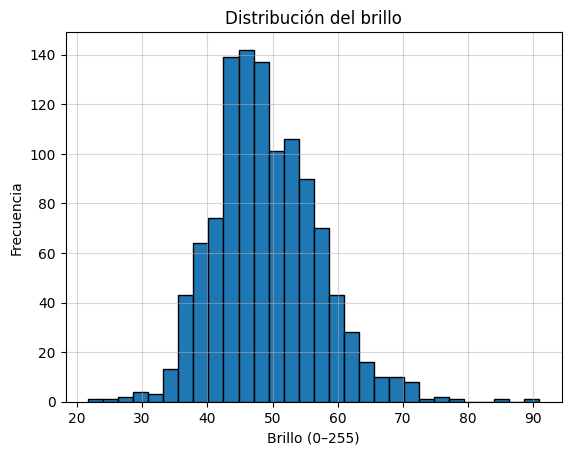

In [13]:
plt.hist(df_vis["brillo"], bins=30, edgecolor="black")
plt.title("Distribución del brillo")
plt.xlabel("Brillo (0–255)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.5)
plt.show()


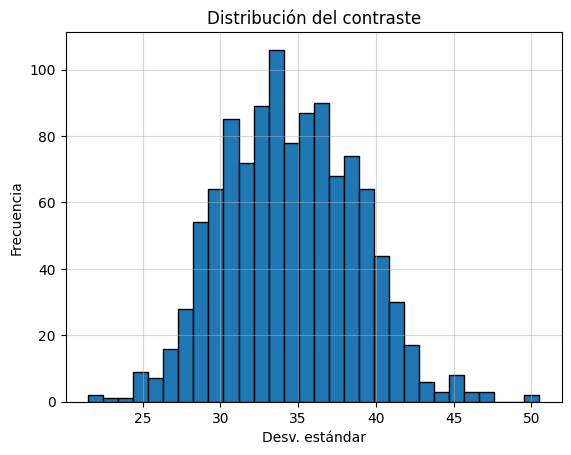

In [14]:
plt.hist(df_vis["contraste"], bins=30, edgecolor="black")
plt.title("Distribución del contraste")
plt.xlabel("Desv. estándar")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.5)
plt.show()


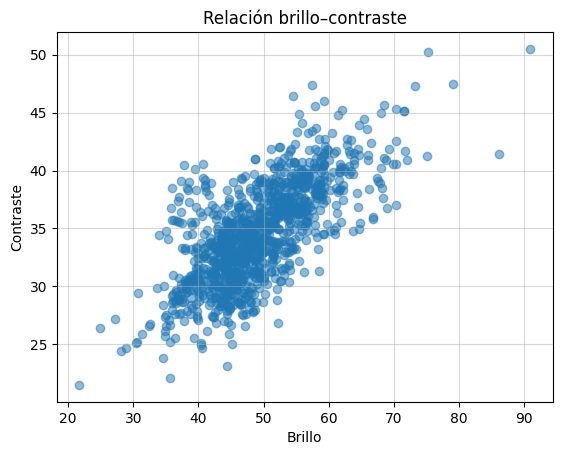

In [15]:
plt.scatter(df_vis["brillo"], df_vis["contraste"], alpha=0.5)
plt.xlabel("Brillo")
plt.ylabel("Contraste")
plt.title("Relación brillo–contraste")
plt.grid(alpha=0.5)
plt.show()


### MEJORA DE IMAGENES 

### Calcular brillo, contraste y saturación de TODAS las imágenes

In [24]:
import os
import random

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,4)

# Ruta del dataset original validado (las 1111 imágenes)
RUTA_ORIGINAL = r"C:\Users\GARI\Documents\DATASETS\img_originales_1111"

# Extensiones válidas
EXT = (".jpg", ".jpeg", ".png")

# Listar imágenes
archivos = [f for f in os.listdir(RUTA_ORIGINAL) if f.lower().endswith(EXT)]
len(archivos)  # deberías ver 1111


1111

### PRUEBA PILOTO DE MEJORA

In [26]:
def mejorar_optimo(ruta_entrada, ruta_salida):

    img = cv2.imread(ruta_entrada)
    if img is None:
        print("Error leyendo:", ruta_entrada)
        return

    # CLAHE suave
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
    L_eq = clahe.apply(L)
    lab_eq = cv2.merge((L_eq, A, B))
    img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # Brillo y contraste afinados
    img_bc = cv2.convertScaleAbs(img_eq, alpha=1.18, beta=20)

    # Saturación leve
    hsv = cv2.cvtColor(img_bc, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:,:,1] *= 1.10
    hsv[:,:,1] = np.clip(hsv[:,:,1], 0, 255)
    img_sat = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Nitidez suave
    blur = cv2.GaussianBlur(img_sat, (0,0), 1.0)
    sharpened = cv2.addWeighted(img_sat, 1.30, blur, -0.30, 0)

    cv2.imwrite(ruta_salida, sharpened)



### Seleccionar 10 imágenes

In [27]:
# Muestra aleatoria de 10 imágenes
muestra = random.sample(archivos, 10)
muestra


['DJI_IMG_1235.jpg',
 'DJI_IMG_1266.jpg',
 'DJI_IMG_0858.jpg',
 'DJI_IMG_0203.jpg',
 'DJI_IMG_1000.jpg',
 'DJI_IMG_0721.jpg',
 'DJI_IMG_0597.jpg',
 'DJI_IMG_0347.jpg',
 'DJI_IMG_0726.jpg',
 'DJI_IMG_1367.jpg']

### carpeta de salida y procesamiento

In [28]:
RUTA_PILOTO_CLAHE = r"C:\Users\GARI\Documents\DATASETS\piloto_clahe"
os.makedirs(RUTA_PILOTO_CLAHE, exist_ok=True)

for nombre in muestra:
    ruta_in = os.path.join(RUTA_ORIGINAL, nombre)
    ruta_out = os.path.join(RUTA_PILOTO_CLAHE, nombre)
    mejorar_con_clahe(ruta_in, ruta_out)

print("Procesamiento piloto con CLAHE completado.")


Procesamiento piloto con CLAHE completado.


### Ver un ejemplo antes / después

In [ ]:
ejemplo = muestra[0]

ruta_in = os.path.join(RUTA_ORIGINAL, ejemplo)
ruta_out = os.path.join(RUTA_PILOTO_CLAHE, ejemplo)

ori = cv2.cvtColor(cv2.imread(ruta_in), cv2.COLOR_BGR2RGB)
mej = cv2.cvtColor(cv2.imread(ruta_out), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(ori)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mej)
plt.title("Mejorada con CLAHE")
plt.axis("off")
plt.show()


### Función para calcular métricas de una imagen

In [30]:
def calcular_estadisticas(ruta):
    img_gray = Image.open(ruta).convert("L")
    arr_gray = np.array(img_gray, dtype=np.float32)

    brillo = arr_gray.mean()
    contraste = arr_gray.std()

    img = cv2.imread(ruta)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturacion = hsv[:,:,1].mean()

    return brillo, contraste, saturacion


### Comparar original vs mejorado (tabla)

In [31]:
estadisticas = []

for nombre in muestra:
    ruta_o = os.path.join(RUTA_ORIGINAL, nombre)
    ruta_m = os.path.join(RUTA_PILOTO_CLAHE, nombre)
    
    bri_o, con_o, sat_o = calcular_estadisticas(ruta_o)
    bri_m, con_m, sat_m = calcular_estadisticas(ruta_m)
    
    estadisticas.append({
        "archivo": nombre,
        "brillo_original": bri_o,
        "brillo_mejorado": bri_m,
        "contraste_original": con_o,
        "contraste_mejorado": con_m,
        "saturacion_original": sat_o,
        "saturacion_mejorada": sat_m
    })

df_piloto = pd.DataFrame(estadisticas)
df_piloto.head()


,archivo,brillo_original,brillo_mejorado,contraste_original,contraste_mejorado,saturacion_original,saturacion_mejorada
0,DJI_IMG_1235.jpg,46.942123,114.482933,29.694094,60.700382,47.686807,25.887437
1,DJI_IMG_1266.jpg,54.888554,120.877525,36.882278,64.832848,62.473244,36.876975
2,DJI_IMG_0858.jpg,46.487343,117.855408,28.939819,63.010799,41.353133,22.474622
3,DJI_IMG_0203.jpg,54.011150,120.420616,41.664486,67.904594,56.237632,31.494674
4,DJI_IMG_1000.jpg,55.600376,124.447571,36.754868,63.738785,62.487461,36.453300


### Resumen promedio antes vs después

In [33]:
resumen = pd.DataFrame([
    {
        "Métrica": "Brillo",
        "Original": df_piloto["brillo_original"].mean(),
        "Mejorado": df_piloto["brillo_mejorado"].mean()
    },
    {
        "Métrica": "Contraste",
        "Original": df_piloto["contraste_original"].mean(),
        "Mejorado": df_piloto["contraste_mejorado"].mean()
    },
    {
        "Métrica": "Saturación",
        "Original": df_piloto["saturacion_original"].mean(),
        "Mejorado": df_piloto["saturacion_mejorada"].mean()
    }
])

resumen


,Métrica,Original,Mejorado
0,Brillo,52.820599,121.233398
1,Contraste,35.975521,64.056366
2,Saturación,51.033298,29.569009


### análisis de las nuevas imágenes 

In [34]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

RUTA_MEJORADO = r"C:\Users\GARI\Documents\DATASETS\DATASET_ORINAL_DESCARTADAS\dataset_eda_con labels\images"

EXT = (".jpg", ".jpeg", ".png")
archivos_mej = [f for f in os.listdir(RUTA_MEJORADO) if f.lower().endswith(EXT)]
len(archivos_mej)


1111

### Guarda tu dataset mejorado completo en una carpeta fija

### EDA del dataset mejorado FINAL

In [35]:
registros_mej = []

for nombre in archivos_mej:
    ruta = os.path.join(RUTA_MEJORADO, nombre)

    # Brillo y contraste
    img_gray = Image.open(ruta).convert("L")
    arr_gray = np.array(img_gray, dtype=np.float32)

    brillo = arr_gray.mean()
    contraste = arr_gray.std()

    # Saturación
    img = cv2.imread(ruta)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturacion = hsv[:,:,1].mean()

    registros_mej.append({
        "archivo": nombre,
        "brillo": brillo,
        "contraste": contraste,
        "saturacion": saturacion
    })

df_vis_mej = pd.DataFrame(registros_mej)
df_vis_mej.describe()


,brillo,contraste,saturacion
count,1111.000000,1111.000000,1111.000000
mean,115.341911,52.435413,45.389536
std,22.510450,4.889875,10.878020
min,70.116112,33.316910,26.553994
25%,98.465733,49.151854,38.147378
50%,112.968506,52.079014,42.471980
75%,125.959766,55.660652,50.155488
max,194.794876,67.316368,99.073649


In [37]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image

RUTA_ORIGINAL = r"C:\Users\GARI\Documents\DATASETS\img_originales_1111"

EXT = (".jpg", ".jpeg", ".png")
archivos_ori = [f for f in os.listdir(RUTA_ORIGINAL) if f.lower().endswith(EXT)]

registros_ori = []

for nombre in archivos_ori:
    ruta = os.path.join(RUTA_ORIGINAL, nombre)

    # Brillo / Contraste
    img_gray = Image.open(ruta).convert("L")
    arr_gray = np.array(img_gray, dtype=np.float32)
    brillo = arr_gray.mean()
    contraste = arr_gray.std()

    # Saturación
    img = cv2.imread(ruta)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturacion = hsv[:,:,1].mean()

    registros_ori.append({
        "archivo": nombre,
        "brillo": brillo,
        "contraste": contraste,
        "saturacion": saturacion
    })

df_vis_original = pd.DataFrame(registros_ori)

df_vis_original.describe()


,brillo,contraste,saturacion
count,1111.000000,1111.000000,1111.000000
mean,49.081337,34.509247,53.805487
std,7.917830,4.280156,10.060564
min,21.724548,21.497786,33.382545
25%,43.942989,31.273349,47.178395
50%,48.358894,34.377560,51.426400
75%,54.063000,37.613491,58.228761
max,90.895721,50.491730,112.790826


### Histogramas antes vs después (gráfico comparativo)

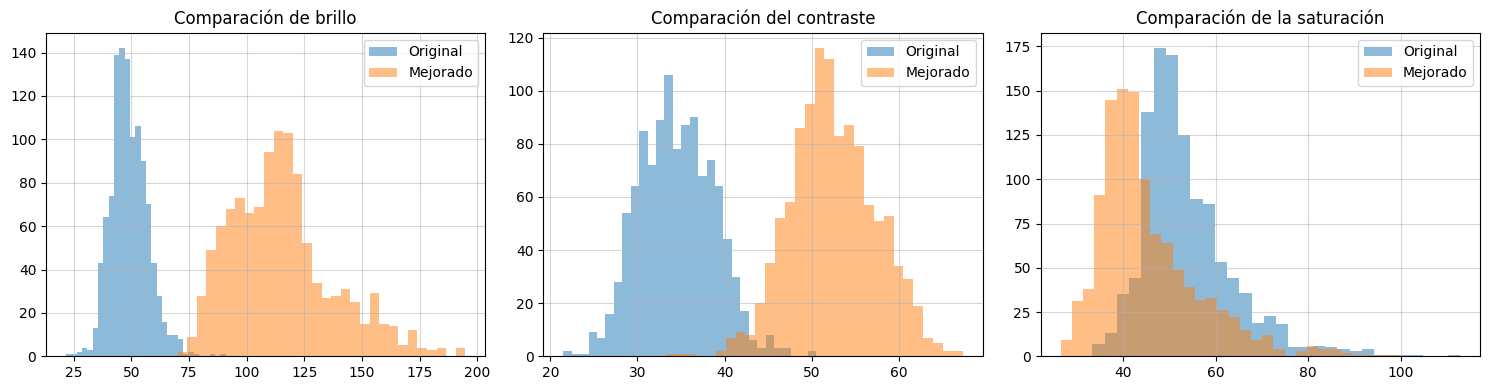

In [38]:
plt.figure(figsize=(15,4))

# BRILLO
plt.subplot(1,3,1)
plt.hist(df_vis_original["brillo"], bins=30, alpha=0.5, label="Original")
plt.hist(df_vis_mej["brillo"], bins=30, alpha=0.5, label="Mejorado")
plt.title("Comparación de brillo")
plt.legend()
plt.grid(alpha=0.5)

# CONTRASTE
plt.subplot(1,3,2)
plt.hist(df_vis_original["contraste"], bins=30, alpha=0.5, label="Original")
plt.hist(df_vis_mej["contraste"], bins=30, alpha=0.5, label="Mejorado")
plt.title("Comparación del contraste")
plt.legend()
plt.grid(alpha=0.5)

# SATURACIÓN
plt.subplot(1,3,3)
plt.hist(df_vis_original["saturacion"], bins=30, alpha=0.5, label="Original")
plt.hist(df_vis_mej["saturacion"], bins=30, alpha=0.5, label="Mejorado")
plt.title("Comparación de la saturación")
plt.legend()
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()
